<a href="https://colab.research.google.com/github/WildJimmy/23-Homework7G4-James/blob/main/configurations_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Equilibrium Configurations for NaCl

Note: Optimization functions are largely taken from https://github.com/ubsuny/CompPhys/blob/main/MinMax/nacl.ipynb

Here we aim to find the equilibrium positions of the third and fourth configurations of the NaCl tetrameters as shown in this paper (https://pubs.aip.org/aapt/ajp/article/66/3/231/1044856/Evolving-few-ion-clusters-of-Na-and-Cl)

I opted to use a randomized guess to find the most stable configurations, then selected those most similar to the two I was seeking. The definitions below are all from the cited notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize

In [3]:
ke2 = 197 / 137  # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0321  # nm      parameter of model
b = 1.0  # eV      regular
c = 0.01  # nm

In [4]:
def cp(l):
    return np.fromiter(
        itertools.chain(*itertools.combinations(l, 2)), dtype=int
    ).reshape(-1, 2)

class Cluster:
    def __init__(self, r_na, r_cl):
        """
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation.
        """
        self.positions = np.concatenate((r_na, r_cl))
        self.charges = np.concatenate(
            [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)]
        )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = (
            self.charges[self.combs][:, 0] * self.charges[self.combs][:, 1]
        )
        self.rij = np.linalg.norm(
            self.positions[self.combs][:, 0] - self.positions[self.combs][:, 1], axis=1
        )

    def Vij(self):
        """Calculate a numpy vector of all of the potentials of the combinations"""
        self.Vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods > 0
        neg = ~pos
        self.Vij_[pos] = ke2 / self.rij[pos] + b * (c / self.rij[pos]) ** 12
        self.Vij_[neg] = (
            -ke2 / self.rij[neg]
            + alpha * np.exp(-self.rij[neg] / rho)
            + b * (c / self.rij[neg]) ** 12
        )
        return self.Vij_

    def V(self):
        """Total potential, which is a sum of the Vij vector"""
        return np.sum(self.Vij())

    def get_vals(self):
        """Positions interpreted as a flat shape"""
        return np.reshape(self.positions, -1)

    def set_vals(self, vals):
        """Inputs flat shape of positions, used by __call__"""
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(
            self.positions[self.combs][:, 0] - self.positions[self.combs][:, 1], axis=1
        )

    def __call__(self, vals):
        """Function that  scipy.optimize.minimize will call"""
        self.set_vals(vals)
        return self.V()

## Determining Optimized Configurations

From here we have two paths to follow. The method I used for determining the optimal configurations for 3 and 4 is essentially a brute force method. The following block initializes random positions for all Na and Cl ions, then optimizes. It checks to see if the potential is around the range we expect, as well as excluding several common configurations we were not searching for (see the relevant comments.) The result is that the loop runs indefinitely until it finds a configuration that works, with some being somewhat strange, and some being the desired configurations. In our case #3 and #4 from the paper.

In [5]:
a = 0.2

while True:

    r_na = np.random.rand(4, 3)
    r_cl = np.random.rand(4, 3)

    cluster = Cluster(r_na, r_cl)
    vals_init = cluster.get_vals()
    # print("initial Na positions:\n", r_na)
    # print("initial Cl positions:\n", r_cl)
    # print("initial positions flattened shape:\n", vals_init)
    # print("initial V  :", cluster.V())

    res = scipy.optimize.minimize(fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
    cluster.set_vals(
        res.x
    )  # For some reason, "minimize" is not updating the class at the last iteration

    if (
        res.fun < -26.9999
        and not np.isclose(res.fun, -28.2358, 0.0005)  # cubic potential
        and not np.isclose(res.fun, -26.1369, 0.0005)  # just a straight line...
        and not np.isclose(res.fun, -27.7824, 0.0005)  # octagon
    ):
        break
print("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

Final optimized cluster positions
[[ 0.29080935  0.38842798  0.6701392 ]
 [ 0.28860656  0.2112047  -0.10049432]
 [ 0.43670676  0.40617825  0.33924627]
 [ 0.14273259  0.19342553  0.23040046]
 [ 0.36971515  0.31186562  0.11353969]
 [ 0.4873078   0.49095195  0.56897054]
 [ 0.20972141  0.28774438  0.45610812]
 [ 0.09211242  0.10866851  0.00067172]]
Final potential: -27.729842280010452


Once the optimal configurations are determined and logged, we can then simply plot them using the same method without the guesswork. For the rectangular

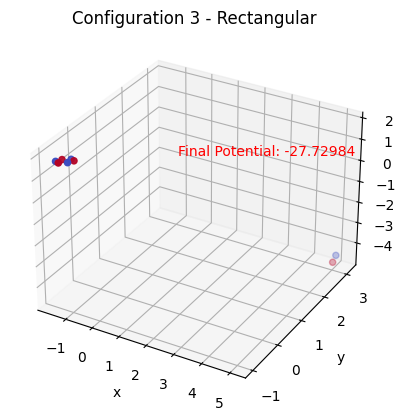

In [6]:
r_na = np.array([[0.34208776, 0.11363288, 0.08778884],
       [0.60453043, 0.18689002, 0.73993221],
       [0.2680503 , 0.48180208, 0.41112085],
       [0.21504881, 0.17410125, 0.19846736]])

r_cl = np.array([[6.85172252e-01, 7.43407844e-01, 5.63663853e-01],
       [6.68399008e-01, 2.68417208e-01, 8.71809252e-02],
       [3.16302762e-01, 1.16067563e-01, 2.93976875e-04],
       [3.96530654e-01, 1.65817255e-01, 1.15196282e-01]])

cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()

res = scipy.optimize.minimize(fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(
        res.x
    )

%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x,y,z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]
ax.scatter( x,y,z, c=charges, cmap='coolwarm' )
ax.text(1, 1, 1, 'Final Potential: -27.72984', color='red')
ax.set_title('Configuration 3 - Rectangular')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()



And then for configuration 4 we have the same deal

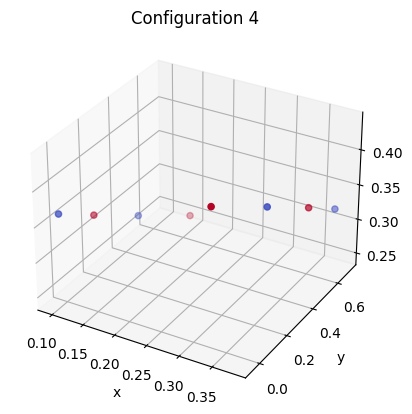

In [9]:
r_na = np.array([[0.65287885, 0.59653953, 0.41133422],
       [0.49587511, 0.52735101, 0.31884368],
       [0.06693635, 0.64654088, 0.33324918],
       [0.61851165, 0.39232723, 0.57213152]])

r_cl = np.array([[0.19212266, 0.73724567, 0.60953698],
       [0.74117061, 0.32366411, 0.24546768],
       [0.25779923, 0.13569068, 0.49482468],
       [0.0475842 , 0.50957145, 0.50969428]])

cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()

res = scipy.optimize.minimize(fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(
        res.x
    )

%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x,y,z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]
ax.scatter( x,y,z, c=charges, cmap='coolwarm' )
ax.text(1, 1, 1, 'Final Potential: -27.33085', color='red')
ax.set_title('Configuration 4')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()